In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,...,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448,1
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352,1
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,...,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352,1
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,...,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056,1


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

# SORRY PAOLINO BUT I HAVE A CHICCO PC AND I CANNOT LOAD IT ALL

# for file in files:

#     if file.endswith('.npy'):
#         file_path = os.path.join(TS_PREPROC_FOLDER, file)
#         # dictionary keys are the file names
#         key = os.path.splitext(file)[0]
#         # load array
#         traces_dict[key] = np.load(file_path, allow_pickle=True)

# traces_dict.keys()

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)


In [5]:
traces = traces_dict[TRACES]
traces.shape

(2452, 27, 27)

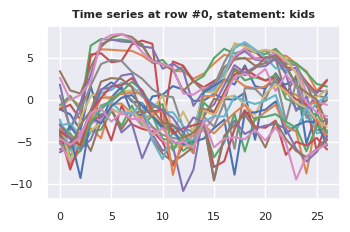

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


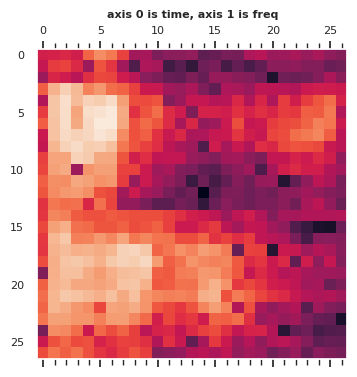

In [7]:
plt.matshow(traces[index]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

In [8]:
from sklearn.model_selection import train_test_split

# Sets tests to be over actor 19 (excluded)
X_test = traces[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  traces[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 27, 27), (387, 27, 27), (520, 27, 27), (1545,), (387,), (520,))

# CNN for statement and syllables 0&2

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [16]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
# Test to check the accuracy of a "belly" network
test_model = build_model((27,27), 2, 
                         n_conv=2, n_hidden=3, hidden_nodes=256)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 23, 8)             1088      
                                                                 
 batch_normalization (BatchN  (None, 23, 8)            32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 8)             0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 19, 8)             328       
                                                                 
 batch_normalization_1 (Batc  (None, 19, 8)            32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 19, 8)             0

In [12]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.2)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-26 19:55:44,425] A new study created in memory with name: no-name-aa4bb789-8f72-42db-8f95-44dc53cdd1c8


Running little bitch having n_conv=2, dropout=0.012689163943316562, hidden_nodes=121
Running little bitch having n_conv=2, dropout=0.19566435845308808, hidden_nodes=142
Running little bitch having n_conv=3, dropout=0.16161772256805462, hidden_nodes=218
Running little bitch having n_conv=3, dropout=0.0730315694059593, hidden_nodes=99


[W 2023-06-26 19:55:44,720] Trial 1 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 142, 'dropout': 0.19566435845308808, 'filters': 8, 'kernel_size': 16, 'batch_size': 50, 'epochs': 17} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.18726974568029944, hidden_nodes=245


[W 2023-06-26 19:55:45,361] Trial 4 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 245, 'dropout': 0.18726974568029944, 'filters': 10, 'kernel_size': 12, 'batch_size': 38, 'epochs': 51} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.1232217316470507, hidden_nodes=34


[W 2023-06-26 19:55:45,843] Trial 5 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 34, 'dropout': 0.1232217316470507, 'filters': 11, 'kernel_size': 12, 'batch_size': 31, 'epochs': 30} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=1, dropout=0.025219905629563867, hidden_nodes=130
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 19:56:06,952] Trial 6 finished with value: 0.9069767441860465 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 130, 'dropout': 0.025219905629563867, 'filters': 7, 'kernel_size': 3, 'batch_size': 28, 'epochs': 9}. Best is trial 6 with value: 0.9069767441860465.


Running little bitch having n_conv=1, dropout=0.03163324338342579, hidden_nodes=53
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 19:56:10,746] Trial 0 finished with value: 0.9534883720930233 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 121, 'dropout': 0.012689163943316562, 'filters': 3, 'kernel_size': 5, 'batch_size': 55, 'epochs': 22}. Best is trial 0 with value: 0.9534883720930233.


Running little bitch having n_conv=2, dropout=0.05939683475165134, hidden_nodes=114


[W 2023-06-26 19:56:11,125] Trial 8 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 114, 'dropout': 0.05939683475165134, 'filters': 3, 'kernel_size': 14, 'batch_size': 26, 'epochs': 32} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 3] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=1, dropout=0.15470762612720737, hidden_nodes=20
Running little bitch having n_conv=3, dropout=0.08608599930155092, hidden_nodes=76


[W 2023-06-26 19:56:11,678] Trial 10 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 76, 'dropout': 0.08608599930155092, 'filters': 15, 'kernel_size': 12, 'batch_size': 23, 'epochs': 16} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=0, dropout=0.003650665557351296, hidden_nodes=133
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 19:56:16,707] Trial 2 finished with value: 0.8449612403100775 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 218, 'dropout': 0.16161772256805462, 'filters': 2, 'kernel_size': 3, 'batch_size': 19, 'epochs': 13}. Best is trial 0 with value: 0.9534883720930233.


Running little bitch having n_conv=2, dropout=0.1506702826520385, hidden_nodes=179
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 19:56:31,422] Trial 7 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 53, 'dropout': 0.03163324338342579, 'filters': 7, 'kernel_size': 10, 'batch_size': 53, 'epochs': 32}. Best is trial 7 with value: 0.979328165374677.


Running little bitch having n_conv=2, dropout=0.11083343121510672, hidden_nodes=213


[W 2023-06-26 19:56:31,876] Trial 13 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 213, 'dropout': 0.11083343121510672, 'filters': 3, 'kernel_size': 12, 'batch_size': 25, 'epochs': 30} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 3] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.0633477598966123, hidden_nodes=217
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 19:56:37,004] Trial 9 finished with value: 0.9948320413436692 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 20, 'dropout': 0.15470762612720737, 'filters': 11, 'kernel_size': 11, 'batch_size': 61, 'epochs': 43}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.011140185297728112, hidden_nodes=245
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 19:56:46,850] Trial 12 finished with value: 0.9870801033591732 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 179, 'dropout': 0.1506702826520385, 'filters': 9, 'kernel_size': 9, 'batch_size': 44, 'epochs': 33}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.06429569494672396, hidden_nodes=25
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 19:56:51,032] Trial 11 finished with value: 0.9741602067183462 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 133, 'dropout': 0.003650665557351296, 'filters': 8, 'kernel_size': 14, 'batch_size': 38, 'epochs': 68}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.07136520725733535, hidden_nodes=40
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 19:57:10,811] Trial 15 finished with value: 0.9121447028423773 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 245, 'dropout': 0.011140185297728112, 'filters': 7, 'kernel_size': 2, 'batch_size': 62, 'epochs': 58}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=3, dropout=0.17970166155275852, hidden_nodes=187
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 19:57:23,684] Trial 17 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 40, 'dropout': 0.07136520725733535, 'filters': 14, 'kernel_size': 9, 'batch_size': 64, 'epochs': 56}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.1896253931015642, hidden_nodes=11
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 19:57:26,983] Trial 16 finished with value: 0.9018087855297158 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 25, 'dropout': 0.06429569494672396, 'filters': 7, 'kernel_size': 2, 'batch_size': 43, 'epochs': 88}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.12599866859443734, hidden_nodes=10
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 19:57:32,451] Trial 14 finished with value: 0.9689922480620154 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 217, 'dropout': 0.0633477598966123, 'filters': 3, 'kernel_size': 9, 'batch_size': 25, 'epochs': 35}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.12154291830436625, hidden_nodes=54
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 19:57:50,970] Trial 18 finished with value: 0.9431524547803618 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 187, 'dropout': 0.17970166155275852, 'filters': 10, 'kernel_size': 2, 'batch_size': 49, 'epochs': 55}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.11689432980540695, hidden_nodes=11


[I 2023-06-26 19:57:51,085] Trial 21 finished with value: 0.9819121447028424 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 54, 'dropout': 0.12154291830436625, 'filters': 14, 'kernel_size': 12, 'batch_size': 64, 'epochs': 53}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.12752705482552848, hidden_nodes=16
13/13 [==============================] - 0s 10ms/step


[I 2023-06-26 19:57:52,145] Trial 20 finished with value: 0.9870801033591732 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 10, 'dropout': 0.12599866859443734, 'filters': 14, 'kernel_size': 10, 'batch_size': 64, 'epochs': 52}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.19309553806378654, hidden_nodes=72
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 19:57:58,135] Trial 19 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 11, 'dropout': 0.1896253931015642, 'filters': 12, 'kernel_size': 15, 'batch_size': 48, 'epochs': 85}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.09881921775843061, hidden_nodes=72
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 19:58:19,679] Trial 22 finished with value: 0.9767441860465116 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 11, 'dropout': 0.11689432980540695, 'filters': 14, 'kernel_size': 12, 'batch_size': 64, 'epochs': 73}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.09045086279268724, hidden_nodes=71
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 19:58:28,155] Trial 24 finished with value: 0.9767441860465116 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 72, 'dropout': 0.19309553806378654, 'filters': 12, 'kernel_size': 7, 'batch_size': 57, 'epochs': 70}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.09433867285361658, hidden_nodes=76
13/13 [==============================] - 0s 4ms/step


[I 2023-06-26 19:58:37,814] Trial 26 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 71, 'dropout': 0.09045086279268724, 'filters': 11, 'kernel_size': 7, 'batch_size': 56, 'epochs': 39}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.14478404408530904, hidden_nodes=45
13/13 [==============================] - 0s 13ms/step


[I 2023-06-26 19:58:40,153] Trial 23 finished with value: 0.9819121447028424 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 16, 'dropout': 0.12752705482552848, 'filters': 12, 'kernel_size': 16, 'batch_size': 59, 'epochs': 72}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.1493625706021185, hidden_nodes=49
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 19:58:47,076] Trial 27 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 76, 'dropout': 0.09433867285361658, 'filters': 11, 'kernel_size': 7, 'batch_size': 58, 'epochs': 44}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.15195224033190188, hidden_nodes=157


[W 2023-06-26 19:58:47,382] Trial 30 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 157, 'dropout': 0.15195224033190188, 'filters': 9, 'kernel_size': 12, 'batch_size': 42, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15271412211335542, hidden_nodes=181


[W 2023-06-26 19:58:47,740] Trial 31 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 181, 'dropout': 0.15271412211335542, 'filters': 9, 'kernel_size': 12, 'batch_size': 41, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15717040489360082, hidden_nodes=167


[W 2023-06-26 19:58:48,142] Trial 32 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 167, 'dropout': 0.15717040489360082, 'filters': 9, 'kernel_size': 12, 'batch_size': 42, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15069190296928675, hidden_nodes=173


[W 2023-06-26 19:58:48,527] Trial 33 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 173, 'dropout': 0.15069190296928675, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1491056533259283, hidden_nodes=166


[W 2023-06-26 19:58:48,917] Trial 34 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 166, 'dropout': 0.1491056533259283, 'filters': 9, 'kernel_size': 12, 'batch_size': 42, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=2, dropout=0.15397242672799974, hidden_nodes=161


[W 2023-06-26 19:58:49,333] Trial 35 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 161, 'dropout': 0.15397242672799974, 'filters': 5, 'kernel_size': 12, 'batch_size': 40, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 5] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1585553301050123, hidden_nodes=164


[W 2023-06-26 19:58:49,733] Trial 36 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 164, 'dropout': 0.1585553301050123, 'filters': 10, 'kernel_size': 12, 'batch_size': 40, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.14678414929668473, hidden_nodes=166


[W 2023-06-26 19:58:50,148] Trial 37 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 166, 'dropout': 0.14678414929668473, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15214522488236693, hidden_nodes=167


[W 2023-06-26 19:58:50,762] Trial 38 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 167, 'dropout': 0.15214522488236693, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15150742816568125, hidden_nodes=180


[W 2023-06-26 19:58:51,298] Trial 39 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 180, 'dropout': 0.15150742816568125, 'filters': 9, 'kernel_size': 12, 'batch_size': 41, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

13/13 [==============================] - 1s 16ms/step


[I 2023-06-26 19:58:51,656] Trial 25 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 72, 'dropout': 0.09881921775843061, 'filters': 12, 'kernel_size': 7, 'batch_size': 57, 'epochs': 74}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.1536901592752157, hidden_nodes=168


[W 2023-06-26 19:58:52,027] Trial 40 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 189, 'dropout': 0.15161319486155841, 'filters': 16, 'kernel_size': 12, 'batch_size': 39, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in 

Running little bitch having n_conv=2, dropout=0.1541653596246462, hidden_nodes=165


[W 2023-06-26 19:58:52,384] Trial 41 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 168, 'dropout': 0.1536901592752157, 'filters': 9, 'kernel_size': 12, 'batch_size': 41, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=2, dropout=0.15328830878780964, hidden_nodes=162
Running little bitch having n_conv=2, dropout=0.15277623791372552, hidden_nodes=157


[W 2023-06-26 19:58:53,152] Trial 43 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 162, 'dropout': 0.15328830878780964, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15399798987142618, hidden_nodes=165
Running little bitch having n_conv=2, dropout=0.15202980454300974, hidden_nodes=172


[W 2023-06-26 19:58:53,880] Trial 45 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 165, 'dropout': 0.15399798987142618, 'filters': 9, 'kernel_size': 12, 'batch_size': 39, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1527012158359692, hidden_nodes=165
Running little bitch having n_conv=2, dropout=0.149442360123766, hidden_nodes=168


[W 2023-06-26 19:58:54,661] Trial 47 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 165, 'dropout': 0.1527012158359692, 'filters': 9, 'kernel_size': 12, 'batch_size': 39, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=2, dropout=0.15079028425842578, hidden_nodes=174


[W 2023-06-26 19:58:55,307] Trial 49 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 174, 'dropout': 0.15079028425842578, 'filters': 9, 'kernel_size': 12, 'batch_size': 39, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15054609006375905, hidden_nodes=165


[W 2023-06-26 19:58:55,876] Trial 50 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 165, 'dropout': 0.15054609006375905, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.14718520498208432, hidden_nodes=161


[W 2023-06-26 19:58:56,561] Trial 51 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 161, 'dropout': 0.14718520498208432, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15235942435243882, hidden_nodes=39


[W 2023-06-26 19:58:57,180] Trial 52 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.15235942435243882, 'filters': 9, 'kernel_size': 12, 'batch_size': 39, 'epochs': 28} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=2, dropout=0.15369546683022164, hidden_nodes=165


[W 2023-06-26 19:58:57,744] Trial 53 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 165, 'dropout': 0.15369546683022164, 'filters': 9, 'kernel_size': 12, 'batch_size': 49, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1481853352345661, hidden_nodes=161


[W 2023-06-26 19:58:58,321] Trial 54 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 161, 'dropout': 0.1481853352345661, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=2, dropout=0.1509546273288475, hidden_nodes=169


[W 2023-06-26 19:58:58,930] Trial 55 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 169, 'dropout': 0.1509546273288475, 'filters': 9, 'kernel_size': 12, 'batch_size': 42, 'epochs': 28} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=2, dropout=0.15385179877005706, hidden_nodes=168


[W 2023-06-26 19:59:00,470] Trial 56 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 168, 'dropout': 0.15385179877005706, 'filters': 9, 'kernel_size': 12, 'batch_size': 38, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15459202679955167, hidden_nodes=163


[W 2023-06-26 19:59:01,264] Trial 57 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 163, 'dropout': 0.15459202679955167, 'filters': 9, 'kernel_size': 12, 'batch_size': 39, 'epochs': 44} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1565235452558792, hidden_nodes=162


[W 2023-06-26 19:59:02,039] Trial 58 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 162, 'dropout': 0.1565235452558792, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bui

Running little bitch having n_conv=2, dropout=0.15228191215176312, hidden_nodes=164


[W 2023-06-26 19:59:02,687] Trial 59 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 164, 'dropout': 0.15228191215176312, 'filters': 5, 'kernel_size': 12, 'batch_size': 41, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 5] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15390957990903437, hidden_nodes=169


[W 2023-06-26 19:59:03,343] Trial 60 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 169, 'dropout': 0.15390957990903437, 'filters': 9, 'kernel_size': 12, 'batch_size': 49, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.14926565203898406, hidden_nodes=164


[W 2023-06-26 19:59:03,911] Trial 61 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 164, 'dropout': 0.14926565203898406, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.15402861285798208, hidden_nodes=162


[W 2023-06-26 19:59:04,436] Trial 62 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 162, 'dropout': 0.15402861285798208, 'filters': 9, 'kernel_size': 12, 'batch_size': 40, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.14867229079715708, hidden_nodes=161
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 19:59:04,905] Trial 28 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 45, 'dropout': 0.14478404408530904, 'filters': 15, 'kernel_size': 12, 'batch_size': 59, 'epochs': 44}. Best is trial 9 with value: 0.9948320413436692.
[W 2023-06-26 19:59:05,048] Trial 63 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 161, 'dropout': 0.14867229079715708, 'filters': 9, 'kernel_size': 12, 'batch_size': 49, 'epochs': 28} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipy

Running little bitch having n_conv=2, dropout=0.16079998706527077, hidden_nodes=153
Running little bitch having n_conv=2, dropout=0.15586698244680564, hidden_nodes=175


[W 2023-06-26 19:59:05,615] Trial 64 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 153, 'dropout': 0.16079998706527077, 'filters': 9, 'kernel_size': 10, 'batch_size': 41, 'epochs': 26} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,9], [1,10,9,9].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 9), dtype=float32)').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = 

Running little bitch having n_conv=2, dropout=0.16032985350101533, hidden_nodes=178
Running little bitch having n_conv=2, dropout=0.15952677886718208, hidden_nodes=164


[W 2023-06-26 19:59:06,842] Trial 67 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 164, 'dropout': 0.15952677886718208, 'filters': 9, 'kernel_size': 10, 'batch_size': 41, 'epochs': 26} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,9], [1,10,9,9].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 9), dtype=float32)').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = 

Running little bitch having n_conv=2, dropout=0.155617804753068, hidden_nodes=158


[W 2023-06-26 19:59:07,893] Trial 68 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 158, 'dropout': 0.155617804753068, 'filters': 9, 'kernel_size': 10, 'batch_size': 40, 'epochs': 27} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,9], [1,10,9,9].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 9), dtype=float32)').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = fu

Running little bitch having n_conv=2, dropout=0.152909854650616, hidden_nodes=173
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 19:59:09,497] Trial 29 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 49, 'dropout': 0.1493625706021185, 'filters': 16, 'kernel_size': 12, 'batch_size': 51, 'epochs': 41}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.16761814600201141, hidden_nodes=37


[W 2023-06-26 19:59:10,342] Trial 70 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.16761814600201141, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 61} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17020266113070798, hidden_nodes=38


[W 2023-06-26 19:59:11,129] Trial 71 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.17020266113070798, 'filters': 15, 'kernel_size': 13, 'batch_size': 51, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16974624312637412, hidden_nodes=35


[W 2023-06-26 19:59:11,852] Trial 72 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 35, 'dropout': 0.16974624312637412, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.1671094518941811, hidden_nodes=39


[W 2023-06-26 19:59:12,556] Trial 73 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.1671094518941811, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.16986560887329538, hidden_nodes=37


[W 2023-06-26 19:59:13,264] Trial 74 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.16986560887329538, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17057340872046026, hidden_nodes=38


[W 2023-06-26 19:59:14,059] Trial 75 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.17057340872046026, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17645527009945022, hidden_nodes=39


[W 2023-06-26 19:59:14,718] Trial 76 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.17645527009945022, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17268619781066305, hidden_nodes=35


[W 2023-06-26 19:59:15,308] Trial 77 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 35, 'dropout': 0.17268619781066305, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.1699870801842919, hidden_nodes=37


[W 2023-06-26 19:59:15,882] Trial 78 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.1699870801842919, 'filters': 16, 'kernel_size': 14, 'batch_size': 51, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.17303959098424807, hidden_nodes=32


[W 2023-06-26 19:59:16,456] Trial 79 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 32, 'dropout': 0.17303959098424807, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17014656916767829, hidden_nodes=38


[W 2023-06-26 19:59:17,268] Trial 80 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.17014656916767829, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16612026352702286, hidden_nodes=38


[W 2023-06-26 19:59:18,231] Trial 81 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.16612026352702286, 'filters': 16, 'kernel_size': 13, 'batch_size': 52, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.170974350870017, hidden_nodes=101


[W 2023-06-26 19:59:19,105] Trial 82 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 101, 'dropout': 0.170974350870017, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1652786240724425, hidden_nodes=36


[W 2023-06-26 19:59:20,123] Trial 83 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 36, 'dropout': 0.1652786240724425, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1735453012372762, hidden_nodes=101


[W 2023-06-26 19:59:21,051] Trial 84 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 101, 'dropout': 0.1735453012372762, 'filters': 16, 'kernel_size': 11, 'batch_size': 51, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16702418267397962, hidden_nodes=41


[W 2023-06-26 19:59:21,846] Trial 85 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 41, 'dropout': 0.16702418267397962, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16734601517394015, hidden_nodes=39


[W 2023-06-26 19:59:22,653] Trial 86 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.16734601517394015, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 63} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17344293708422082, hidden_nodes=40


[W 2023-06-26 19:59:23,557] Trial 87 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 40, 'dropout': 0.17344293708422082, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 63} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16218652812410062, hidden_nodes=35


[W 2023-06-26 19:59:24,336] Trial 88 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 35, 'dropout': 0.16218652812410062, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16151204749551842, hidden_nodes=37


[W 2023-06-26 19:59:25,015] Trial 89 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.16151204749551842, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.1697500482065495, hidden_nodes=38


[W 2023-06-26 19:59:25,660] Trial 90 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.1697500482065495, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.17837626124283215, hidden_nodes=37


[W 2023-06-26 19:59:26,363] Trial 91 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.17837626124283215, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17290419653179817, hidden_nodes=41


[W 2023-06-26 19:59:26,835] Trial 92 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 41, 'dropout': 0.17290419653179817, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16329750724486508, hidden_nodes=35


[W 2023-06-26 19:59:27,443] Trial 93 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 35, 'dropout': 0.16329750724486508, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.1558217469440422, hidden_nodes=36


[W 2023-06-26 19:59:28,406] Trial 94 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 36, 'dropout': 0.1558217469440422, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 61} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.1666123276972507, hidden_nodes=35


[W 2023-06-26 19:59:29,206] Trial 95 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 35, 'dropout': 0.1666123276972507, 'filters': 16, 'kernel_size': 11, 'batch_size': 51, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in bu

Running little bitch having n_conv=2, dropout=0.16598028724445268, hidden_nodes=38


[W 2023-06-26 19:59:29,999] Trial 96 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.16598028724445268, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.17039876236722779, hidden_nodes=37


[W 2023-06-26 19:59:30,845] Trial 97 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.17039876236722779, 'filters': 16, 'kernel_size': 13, 'batch_size': 50, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16969175178628637, hidden_nodes=41


[W 2023-06-26 19:59:31,590] Trial 98 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 41, 'dropout': 0.16969175178628637, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=2, dropout=0.16779199033799663, hidden_nodes=39
13/13 [==============================] - 1s 11ms/step


[W 2023-06-26 19:59:32,354] Trial 99 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.16779199033799663, 'filters': 16, 'kernel_size': 13, 'batch_size': 52, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=1, dropout=0.1789149834609931, hidden_nodes=39
Running little bitch having n_conv=1, dropout=0.17080237631942508, hidden_nodes=39
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 19:59:39,828] Trial 66 finished with value: 0.9767441860465116 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 178, 'dropout': 0.16032985350101533, 'filters': 9, 'kernel_size': 9, 'batch_size': 40, 'epochs': 23}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.173987612361855, hidden_nodes=36
13/13 [==============================] - 1s 13ms/step


[I 2023-06-26 19:59:41,983] Trial 69 finished with value: 0.9819121447028424 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 173, 'dropout': 0.152909854650616, 'filters': 9, 'kernel_size': 9, 'batch_size': 40, 'epochs': 26}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.1764572418799773, hidden_nodes=32
13/13 [==============================] - 0s 5ms/step


[I 2023-06-26 20:00:11,594] Trial 103 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 32, 'dropout': 0.1764572418799773, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 61}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.18185388403888936, hidden_nodes=31
13/13 [==============================] - 0s 4ms/step


[I 2023-06-26 20:00:12,134] Trial 102 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 36, 'dropout': 0.173987612361855, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 64}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.19765074391019197, hidden_nodes=102
 8/13 [=================>............] - ETA: 0s

[I 2023-06-26 20:00:27,859] Trial 101 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.17080237631942508, 'filters': 16, 'kernel_size': 13, 'batch_size': 52, 'epochs': 62}. Best is trial 9 with value: 0.9948320413436692.


13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:00:27,981] Trial 100 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 39, 'dropout': 0.1789149834609931, 'filters': 16, 'kernel_size': 13, 'batch_size': 51, 'epochs': 65}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.19804401463038204, hidden_nodes=101
Running little bitch having n_conv=1, dropout=0.18710590483839984, hidden_nodes=94
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:00:35,056] Trial 105 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 102, 'dropout': 0.19765074391019197, 'filters': 13, 'kernel_size': 11, 'batch_size': 47, 'epochs': 60}. Best is trial 9 with value: 0.9948320413436692.
[I 2023-06-26 20:00:35,204] Trial 104 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 31, 'dropout': 0.18185388403888936, 'filters': 15, 'kernel_size': 14, 'batch_size': 47, 'epochs': 63}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.13846170521607767, hidden_nodes=28
Running little bitch having n_conv=1, dropout=0.16585323676720415, hidden_nodes=93
13/13 [==============================] - 0s 11ms/step


[I 2023-06-26 20:00:55,998] Trial 106 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 101, 'dropout': 0.19804401463038204, 'filters': 13, 'kernel_size': 11, 'batch_size': 61, 'epochs': 49}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.13915285858220916, hidden_nodes=61
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:00:57,159] Trial 107 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 94, 'dropout': 0.18710590483839984, 'filters': 14, 'kernel_size': 11, 'batch_size': 47, 'epochs': 48}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.13783567485506365, hidden_nodes=56
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:01:01,650] Trial 108 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 28, 'dropout': 0.13846170521607767, 'filters': 15, 'kernel_size': 11, 'batch_size': 60, 'epochs': 46}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=3, dropout=0.1582388959967329, hidden_nodes=57
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:01:02,605] Trial 109 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 93, 'dropout': 0.16585323676720415, 'filters': 15, 'kernel_size': 11, 'batch_size': 61, 'epochs': 46}. Best is trial 9 with value: 0.9948320413436692.
[W 2023-06-26 20:01:02,745] Trial 112 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 57, 'dropout': 0.1582388959967329, 'filters': 15, 'kernel_size': 8, 'batch_size': 36, 'epochs': 39} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 6, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ip

Running little bitch having n_conv=3, dropout=0.16152143206148334, hidden_nodes=59
Running little bitch having n_conv=3, dropout=0.16708321075160454, hidden_nodes=151
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:01:32,022] Trial 113 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 59, 'dropout': 0.16152143206148334, 'filters': 13, 'kernel_size': 5, 'batch_size': 54, 'epochs': 17}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.1680238226560479, hidden_nodes=122
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:01:34,420] Trial 111 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 56, 'dropout': 0.13783567485506365, 'filters': 15, 'kernel_size': 5, 'batch_size': 35, 'epochs': 42}. Best is trial 9 with value: 0.9948320413436692.


13/13 [==============================] - 1s 11ms/step
Running little bitch having n_conv=2, dropout=0.16884494643039133, hidden_nodes=124


[I 2023-06-26 20:01:34,779] Trial 110 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 61, 'dropout': 0.13915285858220916, 'filters': 15, 'kernel_size': 11, 'batch_size': 35, 'epochs': 45}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.166845718237765, hidden_nodes=120
13/13 [==============================] - 4s 9ms/step


[I 2023-06-26 20:01:48,091] Trial 114 finished with value: 0.9767441860465116 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 151, 'dropout': 0.16708321075160454, 'filters': 4, 'kernel_size': 5, 'batch_size': 55, 'epochs': 56}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.15780399266465667, hidden_nodes=116
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:02:07,256] Trial 118 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 116, 'dropout': 0.15780399266465667, 'filters': 16, 'kernel_size': 10, 'batch_size': 62, 'epochs': 29}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=2, dropout=0.16819322067331205, hidden_nodes=86


[W 2023-06-26 20:02:08,024] Trial 119 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 86, 'dropout': 0.16819322067331205, 'filters': 16, 'kernel_size': 12, 'batch_size': 62, 'epochs': 40} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in 

Running little bitch having n_conv=2, dropout=0.16825461576998654, hidden_nodes=86
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:02:10,975] Trial 115 finished with value: 0.9741602067183462 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 122, 'dropout': 0.1680238226560479, 'filters': 15, 'kernel_size': 8, 'batch_size': 35, 'epochs': 37}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.16710823327883775, hidden_nodes=91
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:02:24,754] Trial 117 finished with value: 0.958656330749354 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 120, 'dropout': 0.166845718237765, 'filters': 3, 'kernel_size': 8, 'batch_size': 55, 'epochs': 79}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.18191912691019146, hidden_nodes=84
13/13 [==============================] - 1s 14ms/step


[I 2023-06-26 20:02:28,591] Trial 116 finished with value: 0.979328165374677 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 124, 'dropout': 0.16884494643039133, 'filters': 11, 'kernel_size': 8, 'batch_size': 55, 'epochs': 80}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.18228838921672944, hidden_nodes=88


[W 2023-06-26 20:02:29,283] Trial 123 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 88, 'dropout': 0.18228838921672944, 'filters': 5, 'kernel_size': 15, 'batch_size': 44, 'epochs': 40} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 5] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in b

Running little bitch having n_conv=1, dropout=0.15350437683228194, hidden_nodes=92
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:02:43,262] Trial 121 finished with value: 0.9715762273901809 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 91, 'dropout': 0.16710823327883775, 'filters': 5, 'kernel_size': 10, 'batch_size': 61, 'epochs': 51}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.18535995914229936, hidden_nodes=23
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:02:59,999] Trial 122 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 84, 'dropout': 0.18191912691019146, 'filters': 16, 'kernel_size': 14, 'batch_size': 27, 'epochs': 40}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.15555207526101966, hidden_nodes=23
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:03:00,933] Trial 120 finished with value: 0.9741602067183462 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 86, 'dropout': 0.16825461576998654, 'filters': 16, 'kernel_size': 8, 'batch_size': 18, 'epochs': 38}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.15781801292190564, hidden_nodes=43
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:03:04,858] Trial 124 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 92, 'dropout': 0.15350437683228194, 'filters': 16, 'kernel_size': 14, 'batch_size': 27, 'epochs': 40}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.11088307482245863, hidden_nodes=20
13/13 [==============================] - 0s 10ms/step


[I 2023-06-26 20:03:17,686] Trial 127 finished with value: 0.9819121447028424 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 43, 'dropout': 0.15781801292190564, 'filters': 14, 'kernel_size': 12, 'batch_size': 45, 'epochs': 31}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=0, dropout=0.10740529776121661, hidden_nodes=20
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:03:31,904] Trial 125 finished with value: 0.9689922480620154 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 23, 'dropout': 0.18535995914229936, 'filters': 14, 'kernel_size': 14, 'batch_size': 18, 'epochs': 39}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.17562169860145413, hidden_nodes=20
13/13 [==============================] - 0s 11ms/step


[I 2023-06-26 20:03:36,583] Trial 129 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 20, 'dropout': 0.10740529776121661, 'filters': 13, 'kernel_size': 13, 'batch_size': 64, 'epochs': 57}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.17742408441376933, hidden_nodes=44


[W 2023-06-26 20:03:37,094] Trial 131 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 44, 'dropout': 0.17742408441376933, 'filters': 15, 'kernel_size': 15, 'batch_size': 50, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.1739275709464065, hidden_nodes=46


[W 2023-06-26 20:03:37,632] Trial 132 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.1739275709464065, 'filters': 15, 'kernel_size': 15, 'batch_size': 51, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in 

Running little bitch having n_conv=1, dropout=0.17748589362536227, hidden_nodes=46


[W 2023-06-26 20:03:38,177] Trial 133 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.17748589362536227, 'filters': 15, 'kernel_size': 15, 'batch_size': 50, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.17779692648331943, hidden_nodes=42


[W 2023-06-26 20:03:38,669] Trial 134 failed with value None.


Running little bitch having n_conv=1, dropout=0.17587543090929642, hidden_nodes=47


[W 2023-06-26 20:03:39,255] Trial 135 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.17587543090929642, 'filters': 15, 'kernel_size': 15, 'batch_size': 51, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.18048883899453366, hidden_nodes=45


[W 2023-06-26 20:03:39,825] Trial 136 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 45, 'dropout': 0.18048883899453366, 'filters': 15, 'kernel_size': 15, 'batch_size': 50, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.18317157101186907, hidden_nodes=48


[W 2023-06-26 20:03:40,340] Trial 137 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.18317157101186907, 'filters': 15, 'kernel_size': 15, 'batch_size': 50, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.17790439954027415, hidden_nodes=47
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:03:44,451] Trial 126 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 23, 'dropout': 0.15555207526101966, 'filters': 14, 'kernel_size': 12, 'batch_size': 20, 'epochs': 57}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.18672949747582035, hidden_nodes=45
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:03:53,289] Trial 128 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 20, 'dropout': 0.11088307482245863, 'filters': 14, 'kernel_size': 12, 'batch_size': 21, 'epochs': 57}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.1757409193204465, hidden_nodes=51
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:04:11,525] Trial 130 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 20, 'dropout': 0.17562169860145413, 'filters': 13, 'kernel_size': 13, 'batch_size': 50, 'epochs': 67}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.19036136154653316, hidden_nodes=46


[W 2023-06-26 20:04:12,070] Trial 141 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.19036136154653316, 'filters': 15, 'kernel_size': 16, 'batch_size': 57, 'epochs': 52} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.1758641072171869, hidden_nodes=46


[W 2023-06-26 20:04:12,605] Trial 142 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.1758641072171869, 'filters': 15, 'kernel_size': 15, 'batch_size': 58, 'epochs': 52} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in 

Running little bitch having n_conv=1, dropout=0.17697335629717081, hidden_nodes=45


[W 2023-06-26 20:04:13,167] Trial 143 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 45, 'dropout': 0.17697335629717081, 'filters': 15, 'kernel_size': 15, 'batch_size': 53, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.17748330977303223, hidden_nodes=47


[W 2023-06-26 20:04:13,659] Trial 144 failed with value None.


Running little bitch having n_conv=1, dropout=0.19235419992694536, hidden_nodes=51


[W 2023-06-26 20:04:14,230] Trial 145 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 51, 'dropout': 0.19235419992694536, 'filters': 15, 'kernel_size': 15, 'batch_size': 52, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.1799842468901355, hidden_nodes=48


[W 2023-06-26 20:04:14,723] Trial 146 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.1799842468901355, 'filters': 15, 'kernel_size': 15, 'batch_size': 53, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in 

Running little bitch having n_conv=1, dropout=0.19133290200329456, hidden_nodes=46


[W 2023-06-26 20:04:15,284] Trial 147 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.19133290200329456, 'filters': 15, 'kernel_size': 15, 'batch_size': 52, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.17985595211819944, hidden_nodes=48


[W 2023-06-26 20:04:16,283] Trial 149 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.17790774479355087, 'filters': 15, 'kernel_size': 15, 'batch_size': 53, 'epochs': 53} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 15] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1167308510.py", line 27, in

Running little bitch having n_conv=1, dropout=0.17790774479355087, hidden_nodes=46
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:04:18,410] Trial 138 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.17790439954027415, 'filters': 15, 'kernel_size': 13, 'batch_size': 53, 'epochs': 67}. Best is trial 9 with value: 0.9948320413436692.


13/13 [==============================] - 0s 4ms/step


[I 2023-06-26 20:04:21,374] Trial 139 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 45, 'dropout': 0.18672949747582035, 'filters': 15, 'kernel_size': 13, 'batch_size': 50, 'epochs': 65}. Best is trial 9 with value: 0.9948320413436692.


13/13 [==============================] - 0s 3ms/step


[I 2023-06-26 20:04:22,512] Trial 140 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 51, 'dropout': 0.1757409193204465, 'filters': 15, 'kernel_size': 13, 'batch_size': 50, 'epochs': 52}. Best is trial 9 with value: 0.9948320413436692.


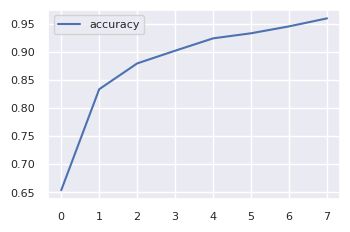

In [13]:
plt.plot(test_model.history.history["accuracy"], label="accuracy")
plt.legend()

In [14]:
best_params = study.best_params
# best_params = dict(n_conv=0, n_hidden=1, hidden_nodes=248, dropout=0.752200, filters=8, kernel_size=14, batch_size=19, epochs=75)

In [23]:
cnn = build_model((27,27), 2, **best_params)
cnn.summary()
cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 17, 11)            3278      
                                                                 
 batch_normalization_9 (Batc  (None, 17, 11)           44        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 17, 11)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 7, 11)             1342      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 11)            44        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 7, 11)            

In [24]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 4ms/step
Cohen k 0.95
Accuracy 0.975
F1-score [0.97465887 0.97533207]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       260
           1       0.96      0.99      0.98       260

    accuracy                           0.97       520
   macro avg       0.98      0.98      0.97       520
weighted avg       0.98      0.97      0.97       520



## CNN and emotion using complete STFT

In [25]:
file_path = os.path.join(TS_PREPROC_FOLDER, f"full_stft.npy")
full_stft = np.load(file_path, allow_pickle=True)


# Sets tests to be over actor 19 (excluded)
X_test = full_stft[df.actor_number > 19]
y_test = df["emotion"][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  full_stft[df.actor_number <= 19], 
                                                    df["emotion"][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 54, 54), (387, 54, 54), (520, 54, 54), (1545,), (387,), (520,))

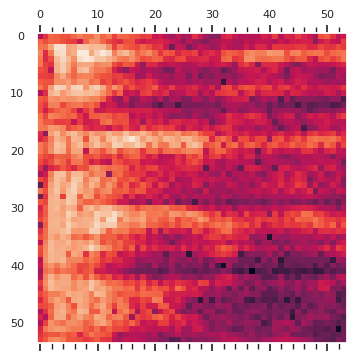

In [34]:
plt.matshow(X_train[0]);
plt.grid(ls="")

In [27]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print(np.unique(y_train))

[0 1 2 3 4 5 6 7]


In [28]:
# Test to check the accuracy of a "belly" network
test_model = build_model((54,54), 8, 
                         n_conv=2, n_hidden=3, hidden_nodes=256)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 50, 8)             2168      
                                                                 
 batch_normalization_11 (Bat  (None, 50, 8)            32        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 50, 8)             0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 46, 8)             328       
                                                                 
 batch_normalization_12 (Bat  (None, 46, 8)            32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 46, 8)            

In [29]:
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-26 20:12:32,475] A new study created in memory with name: no-name-e99838e2-878b-4c39-a998-06e0bb55c56a


Running little bitch having n_conv=0, dropout=0.13389732998663118, hidden_nodes=77
Running little bitch having n_conv=1, dropout=0.10864606777366735, hidden_nodes=45
Running little bitch having n_conv=1, dropout=0.03843971742486407, hidden_nodes=92
Running little bitch having n_conv=3, dropout=0.07232642019447766, hidden_nodes=156
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:13:03,846] Trial 1 finished with value: 0.165374677002584 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 45, 'dropout': 0.10864606777366735, 'filters': 15, 'kernel_size': 12, 'batch_size': 62, 'epochs': 20}. Best is trial 1 with value: 0.165374677002584.


Running little bitch having n_conv=1, dropout=0.1251704391757505, hidden_nodes=237
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:13:05,970] Trial 2 finished with value: 0.1731266149870801 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 92, 'dropout': 0.03843971742486407, 'filters': 9, 'kernel_size': 12, 'batch_size': 33, 'epochs': 15}. Best is trial 2 with value: 0.1731266149870801.


Running little bitch having n_conv=2, dropout=0.036281629551344556, hidden_nodes=215
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:13:09,391] Trial 3 finished with value: 0.13953488372093023 and parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 156, 'dropout': 0.07232642019447766, 'filters': 4, 'kernel_size': 8, 'batch_size': 24, 'epochs': 17}. Best is trial 2 with value: 0.1731266149870801.


Running little bitch having n_conv=1, dropout=0.08811059448019687, hidden_nodes=255
13/13 [==============================] - 0s 10ms/step


[I 2023-06-26 20:13:35,464] Trial 0 finished with value: 0.12919896640826872 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 77, 'dropout': 0.13389732998663118, 'filters': 5, 'kernel_size': 10, 'batch_size': 26, 'epochs': 74}. Best is trial 2 with value: 0.1731266149870801.


Running little bitch having n_conv=2, dropout=0.15763982733977464, hidden_nodes=163
13/13 [==============================] - 0s 9ms/step


[I 2023-06-26 20:13:51,457] Trial 4 finished with value: 0.1343669250645995 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 237, 'dropout': 0.1251704391757505, 'filters': 9, 'kernel_size': 15, 'batch_size': 45, 'epochs': 37}. Best is trial 2 with value: 0.1731266149870801.


Running little bitch having n_conv=1, dropout=0.018777410832010545, hidden_nodes=242
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:14:03,635] Trial 6 finished with value: 0.12919896640826872 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 255, 'dropout': 0.08811059448019687, 'filters': 3, 'kernel_size': 11, 'batch_size': 43, 'epochs': 31}. Best is trial 2 with value: 0.1731266149870801.


Running little bitch having n_conv=0, dropout=0.11131534978547256, hidden_nodes=92
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:14:07,631] Trial 7 finished with value: 0.17829457364341086 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 163, 'dropout': 0.15763982733977464, 'filters': 3, 'kernel_size': 8, 'batch_size': 51, 'epochs': 35}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.0776026751731108, hidden_nodes=20
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:14:24,474] Trial 5 finished with value: 0.1343669250645995 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 215, 'dropout': 0.036281629551344556, 'filters': 6, 'kernel_size': 6, 'batch_size': 32, 'epochs': 78}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.13695626848213313, hidden_nodes=82
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:14:30,087] Trial 10 finished with value: 0.17571059431524547 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 20, 'dropout': 0.0776026751731108, 'filters': 8, 'kernel_size': 9, 'batch_size': 60, 'epochs': 21}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.02212967001775399, hidden_nodes=102
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:14:35,483] Trial 8 finished with value: 0.11627906976744186 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 242, 'dropout': 0.018777410832010545, 'filters': 11, 'kernel_size': 8, 'batch_size': 33, 'epochs': 45}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=3, dropout=0.18808260249159203, hidden_nodes=167
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:14:49,393] Trial 9 finished with value: 0.16279069767441862 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 92, 'dropout': 0.11131534978547256, 'filters': 13, 'kernel_size': 2, 'batch_size': 27, 'epochs': 63}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.1835387809632763, hidden_nodes=161
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:15:04,161] Trial 14 finished with value: 0.13178294573643412 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 161, 'dropout': 0.1835387809632763, 'filters': 2, 'kernel_size': 5, 'batch_size': 58, 'epochs': 7}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=3, dropout=0.16727728825800828, hidden_nodes=23
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:15:07,743] Trial 12 finished with value: 0.11886304909560723 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 102, 'dropout': 0.02212967001775399, 'filters': 8, 'kernel_size': 13, 'batch_size': 33, 'epochs': 13}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=3, dropout=0.15833406329000016, hidden_nodes=13
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:15:35,144] Trial 13 finished with value: 0.1421188630490956 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 167, 'dropout': 0.18808260249159203, 'filters': 2, 'kernel_size': 2, 'batch_size': 50, 'epochs': 56}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.15412574840300164, hidden_nodes=14
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:15:58,793] Trial 11 finished with value: 0.12661498708010335 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 82, 'dropout': 0.13695626848213313, 'filters': 7, 'kernel_size': 10, 'batch_size': 45, 'epochs': 89}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.15912991016075295, hidden_nodes=14
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:16:00,436] Trial 15 finished with value: 0.1421188630490956 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 23, 'dropout': 0.16727728825800828, 'filters': 7, 'kernel_size': 5, 'batch_size': 54, 'epochs': 60}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.0691709936046365, hidden_nodes=192
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:16:02,058] Trial 16 finished with value: 0.14470284237726097 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 13, 'dropout': 0.15833406329000016, 'filters': 7, 'kernel_size': 6, 'batch_size': 52, 'epochs': 57}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.07680259773286388, hidden_nodes=193
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:16:03,772] Trial 17 finished with value: 0.13178294573643412 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 14, 'dropout': 0.15412574840300164, 'filters': 7, 'kernel_size': 6, 'batch_size': 52, 'epochs': 29}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=0, dropout=0.0736060913492769, hidden_nodes=129
13/13 [==============================] - 0s 11ms/step


[I 2023-06-26 20:16:46,870] Trial 21 finished with value: 0.15762273901808785 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 129, 'dropout': 0.0736060913492769, 'filters': 11, 'kernel_size': 16, 'batch_size': 64, 'epochs': 43}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.19826819263849516, hidden_nodes=198
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:16:47,964] Trial 20 finished with value: 0.11369509043927649 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 193, 'dropout': 0.07680259773286388, 'filters': 11, 'kernel_size': 8, 'batch_size': 64, 'epochs': 29}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.09906510361375141, hidden_nodes=128
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:16:54,539] Trial 18 finished with value: 0.14470284237726097 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 14, 'dropout': 0.15912991016075295, 'filters': 11, 'kernel_size': 6, 'batch_size': 54, 'epochs': 28}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.04815610364774407, hidden_nodes=55
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:16:56,609] Trial 19 finished with value: 0.14470284237726097 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 192, 'dropout': 0.0691709936046365, 'filters': 11, 'kernel_size': 7, 'batch_size': 62, 'epochs': 33}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.0476296316270904, hidden_nodes=48
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:17:03,240] Trial 23 finished with value: 0.14728682170542637 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 128, 'dropout': 0.09906510361375141, 'filters': 16, 'kernel_size': 9, 'batch_size': 58, 'epochs': 5}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.05131810922639225, hidden_nodes=53
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:17:15,154] Trial 25 finished with value: 0.1524547803617571 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 48, 'dropout': 0.0476296316270904, 'filters': 9, 'kernel_size': 13, 'batch_size': 39, 'epochs': 5}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.05077818133605874, hidden_nodes=111
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:17:15,788] Trial 24 finished with value: 0.14728682170542637 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 55, 'dropout': 0.04815610364774407, 'filters': 9, 'kernel_size': 13, 'batch_size': 19, 'epochs': 7}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=0, dropout=0.004994430022350477, hidden_nodes=120
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:17:20,941] Trial 22 finished with value: 0.16020671834625322 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 198, 'dropout': 0.19826819263849516, 'filters': 11, 'kernel_size': 8, 'batch_size': 58, 'epochs': 26}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=0, dropout=0.0018271055429681937, hidden_nodes=109
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:17:43,764] Trial 29 finished with value: 0.14728682170542637 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 109, 'dropout': 0.0018271055429681937, 'filters': 13, 'kernel_size': 11, 'batch_size': 39, 'epochs': 21}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.09094667220695477, hidden_nodes=145
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:17:46,601] Trial 28 finished with value: 0.12661498708010335 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 120, 'dropout': 0.004994430022350477, 'filters': 13, 'kernel_size': 11, 'batch_size': 38, 'epochs': 20}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.058586018141768295, hidden_nodes=148
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:17:47,658] Trial 27 finished with value: 0.12144702842377261 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 111, 'dropout': 0.05077818133605874, 'filters': 13, 'kernel_size': 14, 'batch_size': 39, 'epochs': 21}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.13202778923470296, hidden_nodes=145
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:17:55,727] Trial 26 finished with value: 0.17571059431524547 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 53, 'dropout': 0.05131810922639225, 'filters': 9, 'kernel_size': 14, 'batch_size': 18, 'epochs': 22}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=0, dropout=0.09339070831753193, hidden_nodes=65
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:18:08,734] Trial 31 finished with value: 0.1421188630490956 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 148, 'dropout': 0.058586018141768295, 'filters': 4, 'kernel_size': 15, 'batch_size': 49, 'epochs': 13}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.08800791116395049, hidden_nodes=66
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:18:18,572] Trial 30 finished with value: 0.15503875968992248 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 145, 'dropout': 0.09094667220695477, 'filters': 5, 'kernel_size': 10, 'batch_size': 48, 'epochs': 37}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=0, dropout=0.06249934705240248, hidden_nodes=66
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:18:22,840] Trial 33 finished with value: 0.15503875968992248 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 65, 'dropout': 0.09339070831753193, 'filters': 5, 'kernel_size': 10, 'batch_size': 48, 'epochs': 38}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.06338996848514034, hidden_nodes=38
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:18:33,756] Trial 32 finished with value: 0.14728682170542637 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 145, 'dropout': 0.13202778923470296, 'filters': 5, 'kernel_size': 10, 'batch_size': 28, 'epochs': 40}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.034135424430605674, hidden_nodes=79
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:18:43,519] Trial 36 finished with value: 0.14728682170542637 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.06338996848514034, 'filters': 8, 'kernel_size': 12, 'batch_size': 22, 'epochs': 14}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.036128472612580134, hidden_nodes=71
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:18:44,720] Trial 35 finished with value: 0.15503875968992248 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 66, 'dropout': 0.06249934705240248, 'filters': 10, 'kernel_size': 12, 'batch_size': 16, 'epochs': 13}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.03638481658287978, hidden_nodes=33
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:18:50,046] Trial 34 finished with value: 0.1421188630490956 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 66, 'dropout': 0.08800791116395049, 'filters': 5, 'kernel_size': 10, 'batch_size': 21, 'epochs': 39}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.03423943675363339, hidden_nodes=33
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:19:01,271] Trial 37 finished with value: 0.14987080103359174 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 79, 'dropout': 0.034135424430605674, 'filters': 10, 'kernel_size': 12, 'batch_size': 16, 'epochs': 14}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.11112494330034253, hidden_nodes=35
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:19:17,497] Trial 39 finished with value: 0.16795865633074936 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 33, 'dropout': 0.03638481658287978, 'filters': 8, 'kernel_size': 9, 'batch_size': 29, 'epochs': 24}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.11277050031147393, hidden_nodes=90
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:19:19,647] Trial 40 finished with value: 0.14728682170542637 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 33, 'dropout': 0.03423943675363339, 'filters': 8, 'kernel_size': 14, 'batch_size': 35, 'epochs': 24}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.11722330282096446, hidden_nodes=88
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:19:47,827] Trial 41 finished with value: 0.12403100775193798 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 35, 'dropout': 0.11112494330034253, 'filters': 8, 'kernel_size': 14, 'batch_size': 30, 'epochs': 50}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.0791937464061611, hidden_nodes=92
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:20:04,148] Trial 43 finished with value: 0.14987080103359174 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 88, 'dropout': 0.11722330282096446, 'filters': 3, 'kernel_size': 16, 'batch_size': 43, 'epochs': 48}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.02776443558085069, hidden_nodes=53
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:20:12,544] Trial 42 finished with value: 0.14470284237726097 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 90, 'dropout': 0.11277050031147393, 'filters': 6, 'kernel_size': 15, 'batch_size': 43, 'epochs': 51}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.08103370343462499, hidden_nodes=24
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:20:16,598] Trial 38 finished with value: 0.14470284237726097 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 71, 'dropout': 0.036128472612580134, 'filters': 10, 'kernel_size': 12, 'batch_size': 18, 'epochs': 50}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.07980042041704241, hidden_nodes=175
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:20:17,399] Trial 44 finished with value: 0.15503875968992248 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 92, 'dropout': 0.0791937464061611, 'filters': 6, 'kernel_size': 9, 'batch_size': 24, 'epochs': 33}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.05477811854617634, hidden_nodes=176
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:20:32,213] Trial 45 finished with value: 0.13178294573643412 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 53, 'dropout': 0.02776443558085069, 'filters': 6, 'kernel_size': 8, 'batch_size': 26, 'epochs': 33}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.04340124540696521, hidden_nodes=26
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:20:49,765] Trial 48 finished with value: 0.12403100775193798 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 176, 'dropout': 0.05477811854617634, 'filters': 9, 'kernel_size': 7, 'batch_size': 36, 'epochs': 24}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=0, dropout=0.045859601211391765, hidden_nodes=43
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:20:50,801] Trial 46 finished with value: 0.1111111111111111 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 24, 'dropout': 0.08103370343462499, 'filters': 9, 'kernel_size': 9, 'batch_size': 25, 'epochs': 33}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=3, dropout=0.043073874620388176, hidden_nodes=24
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:20:53,091] Trial 49 finished with value: 0.14987080103359174 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 26, 'dropout': 0.04340124540696521, 'filters': 9, 'kernel_size': 7, 'batch_size': 36, 'epochs': 18}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=3, dropout=0.06661288581941616, hidden_nodes=45
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:20:58,674] Trial 47 finished with value: 0.16279069767441862 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 175, 'dropout': 0.07980042041704241, 'filters': 9, 'kernel_size': 9, 'batch_size': 26, 'epochs': 33}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.06757740156165598, hidden_nodes=56
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:21:09,694] Trial 50 finished with value: 0.16020671834625322 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 43, 'dropout': 0.045859601211391765, 'filters': 12, 'kernel_size': 9, 'batch_size': 31, 'epochs': 17}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.06634371916842044, hidden_nodes=56
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:21:22,766] Trial 54 finished with value: 0.16020671834625322 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 56, 'dropout': 0.06634371916842044, 'filters': 16, 'kernel_size': 3, 'batch_size': 60, 'epochs': 10}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.05942738466274694, hidden_nodes=18
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:21:25,960] Trial 53 finished with value: 0.11627906976744186 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 56, 'dropout': 0.06757740156165598, 'filters': 12, 'kernel_size': 3, 'batch_size': 32, 'epochs': 10}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.058214462237092014, hidden_nodes=13
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:21:30,666] Trial 52 finished with value: 0.12403100775193798 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 45, 'dropout': 0.06661288581941616, 'filters': 4, 'kernel_size': 4, 'batch_size': 30, 'epochs': 17}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.05686444963690135, hidden_nodes=15
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:21:31,900] Trial 51 finished with value: 0.15503875968992248 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 24, 'dropout': 0.043073874620388176, 'filters': 14, 'kernel_size': 7, 'batch_size': 29, 'epochs': 17}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.1430579056250295, hidden_nodes=9
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:21:56,493] Trial 55 finished with value: 0.17054263565891473 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 18, 'dropout': 0.05942738466274694, 'filters': 14, 'kernel_size': 11, 'batch_size': 61, 'epochs': 24}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.055541840269151675, hidden_nodes=10
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:22:03,544] Trial 56 finished with value: 0.14728682170542637 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 13, 'dropout': 0.058214462237092014, 'filters': 14, 'kernel_size': 11, 'batch_size': 60, 'epochs': 23}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.023432125044536053, hidden_nodes=10
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:22:04,193] Trial 58 finished with value: 0.1524547803617571 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 9, 'dropout': 0.1430579056250295, 'filters': 7, 'kernel_size': 11, 'batch_size': 61, 'epochs': 26}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.020245483483871868, hidden_nodes=219
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:22:04,845] Trial 57 finished with value: 0.13695090439276486 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 15, 'dropout': 0.05686444963690135, 'filters': 7, 'kernel_size': 11, 'batch_size': 55, 'epochs': 25}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.022203156547577665, hidden_nodes=30
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:22:18,854] Trial 59 finished with value: 0.15762273901808785 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 10, 'dropout': 0.055541840269151675, 'filters': 7, 'kernel_size': 11, 'batch_size': 56, 'epochs': 23}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.02379121485801972, hidden_nodes=31
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:22:40,686] Trial 61 finished with value: 0.12661498708010335 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 219, 'dropout': 0.020245483483871868, 'filters': 8, 'kernel_size': 8, 'batch_size': 57, 'epochs': 27}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=1, dropout=0.07415961586031584, hidden_nodes=32
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:22:44,842] Trial 62 finished with value: 0.17054263565891473 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 30, 'dropout': 0.022203156547577665, 'filters': 10, 'kernel_size': 8, 'batch_size': 56, 'epochs': 29}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.025737703483056776, hidden_nodes=34
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:22:50,866] Trial 63 finished with value: 0.17829457364341086 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 31, 'dropout': 0.02379121485801972, 'filters': 8, 'kernel_size': 13, 'batch_size': 52, 'epochs': 29}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.016574059969191035, hidden_nodes=30
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:23:25,191] Trial 65 finished with value: 0.1524547803617571 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 34, 'dropout': 0.025737703483056776, 'filters': 15, 'kernel_size': 9, 'batch_size': 53, 'epochs': 30}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.10316038989149776, hidden_nodes=22
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:23:31,328] Trial 66 finished with value: 0.13953488372093023 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 30, 'dropout': 0.016574059969191035, 'filters': 15, 'kernel_size': 13, 'batch_size': 52, 'epochs': 30}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.009315922068475252, hidden_nodes=42
13/13 [==============================] - 1s 13ms/step


[I 2023-06-26 20:23:42,785] Trial 60 finished with value: 0.13178294573643412 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 10, 'dropout': 0.023432125044536053, 'filters': 10, 'kernel_size': 11, 'batch_size': 54, 'epochs': 68}. Best is trial 7 with value: 0.17829457364341086.


Running little bitch having n_conv=2, dropout=0.01223075019918344, hidden_nodes=22
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:23:59,305] Trial 68 finished with value: 0.18863049095607234 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 42, 'dropout': 0.009315922068475252, 'filters': 10, 'kernel_size': 13, 'batch_size': 46, 'epochs': 19}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=3, dropout=0.014498714847066926, hidden_nodes=104
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:24:03,191] Trial 67 finished with value: 0.15503875968992248 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 22, 'dropout': 0.10316038989149776, 'filters': 10, 'kernel_size': 13, 'batch_size': 63, 'epochs': 43}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=3, dropout=0.007500111345035112, hidden_nodes=42
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:24:12,321] Trial 64 finished with value: 0.14470284237726097 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 32, 'dropout': 0.07415961586031584, 'filters': 15, 'kernel_size': 13, 'batch_size': 63, 'epochs': 85}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=3, dropout=0.01658742631317341, hidden_nodes=42


[W 2023-06-26 20:24:13,525] Trial 72 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 42, 'dropout': 0.01658742631317341, 'filters': 12, 'kernel_size': 15, 'batch_size': 46, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in b

Running little bitch having n_conv=3, dropout=0.0501452461290535, hidden_nodes=99


[W 2023-06-26 20:24:14,595] Trial 73 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 99, 'dropout': 0.0501452461290535, 'filters': 12, 'kernel_size': 15, 'batch_size': 46, 'epochs': 9} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in bui

Running little bitch having n_conv=3, dropout=0.011565347780636157, hidden_nodes=61


[W 2023-06-26 20:24:15,715] Trial 74 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 61, 'dropout': 0.011565347780636157, 'filters': 12, 'kernel_size': 15, 'batch_size': 45, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.008692360882645186, hidden_nodes=43


[W 2023-06-26 20:24:16,682] Trial 75 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 43, 'dropout': 0.008692360882645186, 'filters': 11, 'kernel_size': 15, 'batch_size': 47, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.005537885609903606, hidden_nodes=41


[W 2023-06-26 20:24:17,324] Trial 76 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 41, 'dropout': 0.005537885609903606, 'filters': 12, 'kernel_size': 15, 'batch_size': 47, 'epochs': 19} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.05142552120809312, hidden_nodes=100


[W 2023-06-26 20:24:18,036] Trial 77 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 100, 'dropout': 0.05142552120809312, 'filters': 12, 'kernel_size': 15, 'batch_size': 47, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in 

Running little bitch having n_conv=3, dropout=0.014659407674969205, hidden_nodes=102


[W 2023-06-26 20:24:18,770] Trial 78 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 102, 'dropout': 0.014659407674969205, 'filters': 12, 'kernel_size': 15, 'batch_size': 46, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in

Running little bitch having n_conv=3, dropout=0.014054001089044366, hidden_nodes=44


[W 2023-06-26 20:24:19,471] Trial 79 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 44, 'dropout': 0.014054001089044366, 'filters': 12, 'kernel_size': 15, 'batch_size': 46, 'epochs': 36} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 12, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/2065572293.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
  File "/tmp/ipykernel_8299/1072382922.py", line 15, in objective_fun
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937663146.py", line 27, in 

Running little bitch having n_conv=2, dropout=0.016588625720052392, hidden_nodes=41
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:24:39,158] Trial 71 finished with value: 0.12403100775193798 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 42, 'dropout': 0.007500111345035112, 'filters': 12, 'kernel_size': 14, 'batch_size': 47, 'epochs': 20}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.014071160020337713, hidden_nodes=50
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:24:49,050] Trial 80 finished with value: 0.16795865633074936 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 41, 'dropout': 0.016588625720052392, 'filters': 12, 'kernel_size': 15, 'batch_size': 46, 'epochs': 20}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.02912300381751616, hidden_nodes=17
13/13 [==============================] - 1s 13ms/step


[I 2023-06-26 20:24:52,681] Trial 70 finished with value: 0.16279069767441862 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 104, 'dropout': 0.014498714847066926, 'filters': 12, 'kernel_size': 13, 'batch_size': 45, 'epochs': 20}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.007459609963692144, hidden_nodes=50
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:25:07,003] Trial 81 finished with value: 0.11886304909560723 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 50, 'dropout': 0.014071160020337713, 'filters': 2, 'kernel_size': 15, 'batch_size': 46, 'epochs': 36}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.029358289670894707, hidden_nodes=73
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:25:14,150] Trial 69 finished with value: 0.1343669250645995 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 22, 'dropout': 0.01223075019918344, 'filters': 12, 'kernel_size': 13, 'batch_size': 50, 'epochs': 86}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.027999549727871977, hidden_nodes=62
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:25:25,703] Trial 84 finished with value: 0.15762273901808785 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 73, 'dropout': 0.029358289670894707, 'filters': 10, 'kernel_size': 12, 'batch_size': 50, 'epochs': 10}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.03886030297242301, hidden_nodes=135
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:25:28,233] Trial 85 finished with value: 0.1421188630490956 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 62, 'dropout': 0.027999549727871977, 'filters': 11, 'kernel_size': 12, 'batch_size': 51, 'epochs': 9}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.04092065441187278, hidden_nodes=82
13/13 [==============================] - 0s 9ms/step


[I 2023-06-26 20:25:41,321] Trial 82 finished with value: 0.16795865633074936 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 17, 'dropout': 0.02912300381751616, 'filters': 11, 'kernel_size': 12, 'batch_size': 51, 'epochs': 28}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.03989484242501799, hidden_nodes=156
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:25:44,466] Trial 83 finished with value: 0.12919896640826872 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 50, 'dropout': 0.007459609963692144, 'filters': 10, 'kernel_size': 12, 'batch_size': 51, 'epochs': 35}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.03876613935672696, hidden_nodes=157
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:25:50,596] Trial 87 finished with value: 0.11369509043927649 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 82, 'dropout': 0.04092065441187278, 'filters': 8, 'kernel_size': 14, 'batch_size': 59, 'epochs': 27}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.050407758198365696, hidden_nodes=156
13/13 [==============================] - 1s 15ms/step


[I 2023-06-26 20:25:51,405] Trial 86 finished with value: 0.16279069767441862 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 135, 'dropout': 0.03886030297242301, 'filters': 11, 'kernel_size': 14, 'batch_size': 59, 'epochs': 27}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.03167792374780409, hidden_nodes=120
13/13 [==============================] - 0s 3ms/step


[I 2023-06-26 20:26:21,115] Trial 89 finished with value: 0.165374677002584 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 157, 'dropout': 0.03876613935672696, 'filters': 3, 'kernel_size': 10, 'batch_size': 59, 'epochs': 41}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.04902389870340099, hidden_nodes=29
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:26:24,267] Trial 88 finished with value: 0.12144702842377261 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 156, 'dropout': 0.03989484242501799, 'filters': 8, 'kernel_size': 14, 'batch_size': 59, 'epochs': 15}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.050613353932541794, hidden_nodes=29
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:26:25,442] Trial 90 finished with value: 0.16279069767441862 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 156, 'dropout': 0.050407758198365696, 'filters': 3, 'kernel_size': 10, 'batch_size': 56, 'epochs': 15}. Best is trial 68 with value: 0.18863049095607234.
[I 2023-06-26 20:26:25,540] Trial 91 finished with value: 0.1524547803617571 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 120, 'dropout': 0.03167792374780409, 'filters': 9, 'kernel_size': 8, 'batch_size': 41, 'epochs': 14}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.03367377480725604, hidden_nodes=19
Running little bitch having n_conv=1, dropout=0.02131732989178714, hidden_nodes=28
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:26:32,436] Trial 92 finished with value: 0.12144702842377261 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 29, 'dropout': 0.04902389870340099, 'filters': 8, 'kernel_size': 8, 'batch_size': 42, 'epochs': 15}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.021047073978928597, hidden_nodes=37
13/13 [==============================] - 0s 3ms/step


[I 2023-06-26 20:26:56,545] Trial 94 finished with value: 0.12661498708010335 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 0.03367377480725604, 'filters': 9, 'kernel_size': 8, 'batch_size': 21, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.02412124811300872, hidden_nodes=60
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:26:58,206] Trial 93 finished with value: 0.14728682170542637 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 29, 'dropout': 0.050613353932541794, 'filters': 9, 'kernel_size': 8, 'batch_size': 42, 'epochs': 23}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.020429010228643203, hidden_nodes=40
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:26:58,989] Trial 95 finished with value: 0.13953488372093023 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 28, 'dropout': 0.02131732989178714, 'filters': 9, 'kernel_size': 8, 'batch_size': 22, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.025121899562467766, hidden_nodes=38
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:27:02,121] Trial 96 finished with value: 0.17571059431524547 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.021047073978928597, 'filters': 9, 'kernel_size': 7, 'batch_size': 57, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.00177750459144016, hidden_nodes=60
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:27:21,924] Trial 98 finished with value: 0.14728682170542637 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 40, 'dropout': 0.020429010228643203, 'filters': 7, 'kernel_size': 9, 'batch_size': 55, 'epochs': 18}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.0006229488479111908, hidden_nodes=59
13/13 [==============================] - 0s 5ms/step


[I 2023-06-26 20:27:23,292] Trial 100 finished with value: 0.1524547803617571 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 60, 'dropout': 0.00177750459144016, 'filters': 10, 'kernel_size': 6, 'batch_size': 56, 'epochs': 18}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.025241304555945112, hidden_nodes=38
13/13 [==============================] - 1s 5ms/step


[I 2023-06-26 20:27:24,723] Trial 97 finished with value: 0.16020671834625322 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 60, 'dropout': 0.02412124811300872, 'filters': 9, 'kernel_size': 7, 'batch_size': 56, 'epochs': 31}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.04450176338308587, hidden_nodes=37
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:27:32,258] Trial 99 finished with value: 0.16795865633074936 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 38, 'dropout': 0.025121899562467766, 'filters': 7, 'kernel_size': 7, 'batch_size': 57, 'epochs': 18}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.045115870844165254, hidden_nodes=47
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:27:46,697] Trial 103 finished with value: 0.14987080103359174 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.04450176338308587, 'filters': 8, 'kernel_size': 7, 'batch_size': 61, 'epochs': 25}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.03492406787853887, hidden_nodes=19
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:27:49,122] Trial 101 finished with value: 0.15762273901808785 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 59, 'dropout': 0.0006229488479111908, 'filters': 10, 'kernel_size': 6, 'batch_size': 57, 'epochs': 31}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.03510222906499069, hidden_nodes=47
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:27:55,437] Trial 104 finished with value: 0.1524547803617571 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.045115870844165254, 'filters': 8, 'kernel_size': 9, 'batch_size': 54, 'epochs': 25}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.03653767485024261, hidden_nodes=19
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:27:59,074] Trial 102 finished with value: 0.1524547803617571 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 38, 'dropout': 0.025241304555945112, 'filters': 8, 'kernel_size': 7, 'batch_size': 61, 'epochs': 31}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.03219779712056416, hidden_nodes=19
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:28:15,182] Trial 107 finished with value: 0.13695090439276486 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 0.03653767485024261, 'filters': 8, 'kernel_size': 10, 'batch_size': 33, 'epochs': 12}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.03404110554336416, hidden_nodes=255


[I 2023-06-26 20:28:15,372] Trial 105 finished with value: 0.165374677002584 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 0.03492406787853887, 'filters': 6, 'kernel_size': 9, 'batch_size': 53, 'epochs': 31}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=0, dropout=0.06026399036458297, hidden_nodes=24
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:28:20,826] Trial 106 finished with value: 0.15503875968992248 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 47, 'dropout': 0.03510222906499069, 'filters': 8, 'kernel_size': 9, 'batch_size': 53, 'epochs': 25}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=0, dropout=0.06081718961644298, hidden_nodes=187
13/13 [==============================] - 1s 13ms/step


[I 2023-06-26 20:28:21,551] Trial 108 finished with value: 0.15762273901808785 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 0.03219779712056416, 'filters': 6, 'kernel_size': 5, 'batch_size': 53, 'epochs': 28}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.00948992259236225, hidden_nodes=166
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:28:41,829] Trial 110 finished with value: 0.14470284237726097 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 24, 'dropout': 0.06026399036458297, 'filters': 4, 'kernel_size': 14, 'batch_size': 34, 'epochs': 29}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.010085709512609363, hidden_nodes=70
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:28:43,988] Trial 111 finished with value: 0.12661498708010335 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 187, 'dropout': 0.06081718961644298, 'filters': 4, 'kernel_size': 13, 'batch_size': 49, 'epochs': 29}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.01720252884201271, hidden_nodes=44
13/13 [==============================] - 1s 12ms/step


[I 2023-06-26 20:28:45,119] Trial 109 finished with value: 0.1524547803617571 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 255, 'dropout': 0.03404110554336416, 'filters': 6, 'kernel_size': 9, 'batch_size': 53, 'epochs': 35}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.01789927711747114, hidden_nodes=52
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:28:52,603] Trial 112 finished with value: 0.1343669250645995 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 166, 'dropout': 0.00948992259236225, 'filters': 14, 'kernel_size': 15, 'batch_size': 48, 'epochs': 20}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.017665100125154563, hidden_nodes=34
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:29:17,731] Trial 113 finished with value: 0.15503875968992248 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 70, 'dropout': 0.010085709512609363, 'filters': 13, 'kernel_size': 15, 'batch_size': 37, 'epochs': 20}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.019386677882431886, hidden_nodes=45
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:29:23,940] Trial 114 finished with value: 0.1343669250645995 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 44, 'dropout': 0.01720252884201271, 'filters': 14, 'kernel_size': 15, 'batch_size': 37, 'epochs': 20}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.018170220542406558, hidden_nodes=34
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:29:24,831] Trial 116 finished with value: 0.13953488372093023 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 34, 'dropout': 0.017665100125154563, 'filters': 9, 'kernel_size': 15, 'batch_size': 45, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.012777528239116558, hidden_nodes=53
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:29:40,445] Trial 117 finished with value: 0.1731266149870801 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 45, 'dropout': 0.019386677882431886, 'filters': 9, 'kernel_size': 13, 'batch_size': 46, 'epochs': 21}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.012328515319851973, hidden_nodes=8
 1/13 [=>............................] - ETA: 10s

[I 2023-06-26 20:29:43,190] Trial 115 finished with value: 0.14987080103359174 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 52, 'dropout': 0.01789927711747114, 'filters': 9, 'kernel_size': 15, 'batch_size': 37, 'epochs': 21}. Best is trial 68 with value: 0.18863049095607234.


13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:29:43,361] Trial 119 finished with value: 0.11627906976744186 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 53, 'dropout': 0.012777528239116558, 'filters': 10, 'kernel_size': 16, 'batch_size': 63, 'epochs': 12}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.011836752276457582, hidden_nodes=27
Running little bitch having n_conv=2, dropout=0.00481597636286462, hidden_nodes=33
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:29:50,682] Trial 118 finished with value: 0.16279069767441862 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 34, 'dropout': 0.018170220542406558, 'filters': 9, 'kernel_size': 13, 'batch_size': 44, 'epochs': 24}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.004944641294769882, hidden_nodes=14
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:30:13,097] Trial 122 finished with value: 0.15762273901808785 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 33, 'dropout': 0.00481597636286462, 'filters': 11, 'kernel_size': 13, 'batch_size': 46, 'epochs': 16}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.05348962949712502, hidden_nodes=42
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:30:15,066] Trial 123 finished with value: 0.14728682170542637 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 14, 'dropout': 0.004944641294769882, 'filters': 10, 'kernel_size': 14, 'batch_size': 47, 'epochs': 16}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.02912972934262729, hidden_nodes=95
13/13 [==============================] - 1s 48ms/step


[I 2023-06-26 20:30:17,755] Trial 120 finished with value: 0.12919896640826872 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 8, 'dropout': 0.012328515319851973, 'filters': 10, 'kernel_size': 13, 'batch_size': 28, 'epochs': 24}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.029178046056110928, hidden_nodes=42
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:30:18,740] Trial 121 finished with value: 0.1343669250645995 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 27, 'dropout': 0.011836752276457582, 'filters': 10, 'kernel_size': 8, 'batch_size': 44, 'epochs': 16}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.05409480766318112, hidden_nodes=42
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:30:50,537] Trial 125 finished with value: 0.1343669250645995 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 95, 'dropout': 0.02912972934262729, 'filters': 9, 'kernel_size': 12, 'batch_size': 18, 'epochs': 19}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.05294441733412415, hidden_nodes=42
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:30:54,470] Trial 124 finished with value: 0.11627906976744186 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 42, 'dropout': 0.05348962949712502, 'filters': 13, 'kernel_size': 12, 'batch_size': 40, 'epochs': 19}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.022782992354008776, hidden_nodes=42
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:30:59,378] Trial 127 finished with value: 0.16795865633074936 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 42, 'dropout': 0.05409480766318112, 'filters': 13, 'kernel_size': 12, 'batch_size': 17, 'epochs': 19}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.02338137992211068, hidden_nodes=27
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:31:06,426] Trial 126 finished with value: 0.18087855297157623 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 42, 'dropout': 0.029178046056110928, 'filters': 13, 'kernel_size': 12, 'batch_size': 18, 'epochs': 26}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.04138974373463607, hidden_nodes=77
13/13 [==============================] - 0s 4ms/step


[I 2023-06-26 20:31:40,219] Trial 131 finished with value: 0.1111111111111111 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 77, 'dropout': 0.04138974373463607, 'filters': 15, 'kernel_size': 11, 'batch_size': 58, 'epochs': 26}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.028829308279234404, hidden_nodes=46
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:31:45,988] Trial 128 finished with value: 0.15762273901808785 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 42, 'dropout': 0.05294441733412415, 'filters': 16, 'kernel_size': 12, 'batch_size': 40, 'epochs': 34}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.02248138984595832, hidden_nodes=135
13/13 [==============================] - 0s 8ms/step


[I 2023-06-26 20:31:52,213] Trial 129 finished with value: 0.12144702842377261 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 42, 'dropout': 0.022782992354008776, 'filters': 11, 'kernel_size': 16, 'batch_size': 62, 'epochs': 26}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.029215008751368406, hidden_nodes=26
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:31:55,126] Trial 130 finished with value: 0.11627906976744186 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 27, 'dropout': 0.02338137992211068, 'filters': 11, 'kernel_size': 16, 'batch_size': 60, 'epochs': 26}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.026755444809063184, hidden_nodes=49
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:32:03,958] Trial 132 finished with value: 0.11369509043927649 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 46, 'dropout': 0.028829308279234404, 'filters': 14, 'kernel_size': 14, 'batch_size': 22, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.047063206068791975, hidden_nodes=30
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:32:33,829] Trial 133 finished with value: 0.13953488372093023 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 135, 'dropout': 0.02248138984595832, 'filters': 14, 'kernel_size': 13, 'batch_size': 19, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.03031490042004383, hidden_nodes=203
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:32:49,203] Trial 134 finished with value: 0.12403100775193798 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 26, 'dropout': 0.029215008751368406, 'filters': 14, 'kernel_size': 13, 'batch_size': 22, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.04813886270060586, hidden_nodes=204
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:32:52,646] Trial 135 finished with value: 0.1343669250645995 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.026755444809063184, 'filters': 14, 'kernel_size': 13, 'batch_size': 22, 'epochs': 22}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.08441814709610981, hidden_nodes=210
13/13 [==============================] - 1s 10ms/step


[I 2023-06-26 20:33:04,854] Trial 137 finished with value: 0.15762273901808785 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 203, 'dropout': 0.03031490042004383, 'filters': 12, 'kernel_size': 8, 'batch_size': 19, 'epochs': 23}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.0384828006410826, hidden_nodes=55
13/13 [==============================] - 1s 11ms/step


[I 2023-06-26 20:33:16,945] Trial 136 finished with value: 0.14470284237726097 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 30, 'dropout': 0.047063206068791975, 'filters': 14, 'kernel_size': 13, 'batch_size': 20, 'epochs': 55}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=1, dropout=0.03979940019464097, hidden_nodes=55
13/13 [==============================] - 0s 7ms/step


[I 2023-06-26 20:33:29,829] Trial 140 finished with value: 0.16020671834625322 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 55, 'dropout': 0.0384828006410826, 'filters': 9, 'kernel_size': 10, 'batch_size': 55, 'epochs': 28}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.015447863422527977, hidden_nodes=19
13/13 [==============================] - 1s 9ms/step


[I 2023-06-26 20:33:32,055] Trial 139 finished with value: 0.14728682170542637 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 210, 'dropout': 0.08441814709610981, 'filters': 12, 'kernel_size': 10, 'batch_size': 20, 'epochs': 28}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.02031166060432685, hidden_nodes=18
13/13 [==============================] - 0s 10ms/step


[I 2023-06-26 20:33:39,799] Trial 141 finished with value: 0.15503875968992248 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 55, 'dropout': 0.03979940019464097, 'filters': 9, 'kernel_size': 11, 'batch_size': 50, 'epochs': 28}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.07075514381622966, hidden_nodes=17
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:33:40,675] Trial 138 finished with value: 0.14987080103359174 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 204, 'dropout': 0.04813886270060586, 'filters': 9, 'kernel_size': 11, 'batch_size': 20, 'epochs': 27}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.06987679301524281, hidden_nodes=16
13/13 [==============================] - 0s 3ms/step


[I 2023-06-26 20:34:15,484] Trial 144 finished with value: 0.17571059431524547 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 17, 'dropout': 0.07075514381622966, 'filters': 13, 'kernel_size': 12, 'batch_size': 51, 'epochs': 32}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.07298955402621435, hidden_nodes=22
13/13 [==============================] - 0s 5ms/step


[I 2023-06-26 20:34:16,424] Trial 145 finished with value: 0.13695090439276486 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 16, 'dropout': 0.06987679301524281, 'filters': 11, 'kernel_size': 12, 'batch_size': 48, 'epochs': 24}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.07658431315092988, hidden_nodes=22
13/13 [==============================] - 1s 7ms/step


[I 2023-06-26 20:34:21,618] Trial 142 finished with value: 0.165374677002584 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 19, 'dropout': 0.015447863422527977, 'filters': 12, 'kernel_size': 11, 'batch_size': 47, 'epochs': 27}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.06331131688913082, hidden_nodes=37
13/13 [==============================] - 1s 8ms/step


[I 2023-06-26 20:34:24,313] Trial 143 finished with value: 0.1421188630490956 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 18, 'dropout': 0.02031166060432685, 'filters': 11, 'kernel_size': 12, 'batch_size': 49, 'epochs': 32}. Best is trial 68 with value: 0.18863049095607234.


Running little bitch having n_conv=2, dropout=0.07238053627876535, hidden_nodes=36
13/13 [==============================] - 0s 6ms/step


[I 2023-06-26 20:35:01,455] Trial 148 finished with value: 0.13953488372093023 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 37, 'dropout': 0.06331131688913082, 'filters': 13, 'kernel_size': 14, 'batch_size': 51, 'epochs': 32}. Best is trial 68 with value: 0.18863049095607234.


13/13 [==============================] - 0s 3ms/step


[I 2023-06-26 20:35:04,619] Trial 149 finished with value: 0.14728682170542637 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 36, 'dropout': 0.07238053627876535, 'filters': 13, 'kernel_size': 7, 'batch_size': 24, 'epochs': 30}. Best is trial 68 with value: 0.18863049095607234.


13/13 [==============================] - 0s 3ms/step


[I 2023-06-26 20:35:05,212] Trial 146 finished with value: 0.12661498708010335 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 22, 'dropout': 0.07298955402621435, 'filters': 13, 'kernel_size': 12, 'batch_size': 48, 'epochs': 32}. Best is trial 68 with value: 0.18863049095607234.


13/13 [==============================] - 0s 4ms/step


[I 2023-06-26 20:35:06,643] Trial 147 finished with value: 0.1421188630490956 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 22, 'dropout': 0.07658431315092988, 'filters': 13, 'kernel_size': 14, 'batch_size': 49, 'epochs': 38}. Best is trial 68 with value: 0.18863049095607234.


In [35]:
best_params = study.best_params
print(best_params)
cnn = build_model((54,54), 8, **best_params)
cnn.summary()
cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

{'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 42, 'dropout': 0.009315922068475252, 'filters': 10, 'kernel_size': 13, 'batch_size': 46, 'epochs': 19}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 42, 10)            7030      
                                                                 
 batch_normalization_17 (Bat  (None, 42, 10)           40        
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 42, 10)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 30, 10)            1310      
                                                                 
 batch_normalization_18 (Bat  (None, 30, 10)           40        
 chNormalization)                     

In [32]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 1s 10ms/step
Cohen k 0.00240880935994503
Accuracy 0.1423076923076923
F1-score [0.07936508 0.17989418 0.         0.22966507 0.15028902 0.02898551
 0.09160305 0.18181818]
              precision    recall  f1-score   support

           0       0.11      0.06      0.08        80
           1       0.16      0.21      0.18        80
           2       0.00      0.00      0.00        40
           3       0.19      0.30      0.23        80
           4       0.14      0.16      0.15        80
           5       0.03      0.03      0.03        40
           6       0.12      0.07      0.09        80
           7       0.17      0.20      0.18        40

    accuracy                           0.14       520
   macro avg       0.11      0.13      0.12       520
weighted avg       0.12      0.14      0.13       520

